In [1]:
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Lambda, Cropping2D
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D


Using TensorFlow backend.


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [4]:
#import keras
#print(keras.__version__) # to find the Keras document for related version

## Data Preparation

In [5]:
lines = []
images = []
measurements = []

### Include left and right cam data to create "recovering back to center" data

In [6]:
  # read rows in driving_log.csv
with open('newdata/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    
    for line in reader:
        lines.append(line)

# read images and steering measurements 
for line in lines:
    # create adjusted steering measurements for the side camera images
    correction = 0.20 # this is a parameter to tune
    measurement_center = float(line[3])
    measurement_left = measurement_center + correction
    measurement_right = measurement_center - correction
    
    
    # line is the row of the data set    
    #local_path = 'D:\\OneDrive\\Documents\\SDCN\\Term 1\\Behavioral Cloning\\udacitydata\\IMG\\'
    local_path = ''
    source_path_center = line[0].split('/')[-1]
    source_path_left = line[1].split('/')[-1]
    source_path_right = line[2].split('/')[-1]

    curr_path_center = local_path + source_path_center
    curr_path_left = local_path + source_path_left
    curr_path_right = local_path + source_path_right
    
    #print(curr_path_center)
    #print(curr_path_left)
    #print(curr_path_right)
    
    img_center = cv2.imread(curr_path_center)
    img_left = cv2.imread(curr_path_left)
    img_right = cv2.imread(curr_path_right)
    
    # convert image back to RGB since cv2 read image in BGR format
    img_center = cv2.cvtColor(img_center, cv2.COLOR_BGR2RGB)
    img_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2RGB)
    img_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2RGB)
    
    # Image as feature
    images.append(img_center)
    images.append(img_left)
    images.append(img_right)

    # measurement as labels
    measurements.append(measurement_center)
    measurements.append(measurement_left)
    measurements.append(measurement_right)

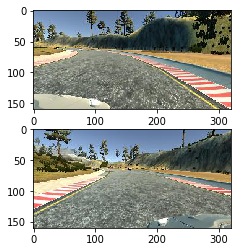

In [7]:
# make sure image in RBG format
plt.figure(1)
plt.subplot(211)
plt.imshow(images[2])

plt.subplot(212)
plt.imshow(images[235])
plt.show()

In [8]:
print(len(images))
print(len(measurements))

7386
7386


# Data Exploration

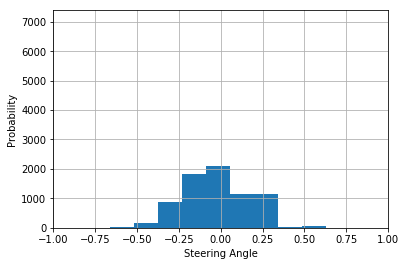

In [9]:
plt.hist(measurements)
plt.xlabel('Steering Angle')
plt.ylabel('Probability')
plt.axis([-1, 1, 0, len(measurements)])
plt.grid(True)
plt.show()

In [10]:
plt.close('all')

# Create Validaiton Set

In [11]:
# Divide data into training and validation set
images_train, images_val, measurements_train, measurements_val = train_test_split(images, measurements, test_size=0.3, random_state=0)


# Data Augumentation

In [12]:
# data argumentation
augmented_images, augmented_measurements = [], []

In [13]:
def augment_brightness_camera_images(image):
    image_adjusted = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    image_adjusted = np.array(image_adjusted, dtype = np.float64)
    random_bright = .5+np.random.uniform()
    image_adjusted[:,:,2] = image_adjusted[:,:,2]*random_bright
    image_adjusted[:,:,2][image_adjusted[:,:,2]>255]  = 255
    image_adjusted = np.array(image_adjusted, dtype = np.uint8)
    image_adjusted = cv2.cvtColor(image_adjusted,cv2.COLOR_HSV2RGB)
    return image_adjusted

In [14]:
def add_random_shadow(image):
    top_y = 320*np.random.uniform()
    top_x = 0
    bot_x = 160
    bot_y = 320*np.random.uniform()
    image_hls = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    shadow_mask = 0*image_hls[:,:,1]
    X_m = np.mgrid[0:image.shape[0],0:image.shape[1]][0]
    Y_m = np.mgrid[0:image.shape[0],0:image.shape[1]][1]
    shadow_mask[((X_m-top_x)*(bot_y-top_y) -(bot_x - top_x)*(Y_m-top_y) >=0)]=1
    #random_bright = .25+.7*np.random.uniform()
    if np.random.randint(2)==1:
        random_bright = .5
        cond1 = shadow_mask==1
        cond0 = shadow_mask==0
        if np.random.randint(2)==1:
            image_hls[:,:,1][cond1] = image_hls[:,:,1][cond1]*random_bright
        else:
            image_hls[:,:,1][cond0] = image_hls[:,:,1][cond0]*random_bright
            
    image = cv2.cvtColor(image_hls,cv2.COLOR_HLS2RGB)
    return image

In [15]:
## to fix left bias since when training most of the time the car turning left
# genrate more new right turn iamges by flip all left turn images to right turn images 
for image, measurement in zip(images_train, measurements_train):
        augmented_images.append(image)
        augmented_measurements.append(measurement)
        
        augmented_images.append(augment_brightness_camera_images(image))
        augmented_measurements.append(measurement)
        
        augmented_images.append(add_random_shadow(image))
        augmented_measurements.append(measurement)
        
        r = np.random.uniform() # randomly flip data with 0.5 percent chance
        if r > .5:
            augmented_images.append(cv2.flip(image,1))
            augmented_measurements.append(measurement*-1.0)
        

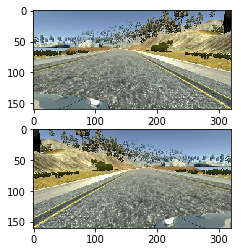

In [16]:
# make sure image in RBG format
plt.figure(1)
plt.subplot(211)
plt.imshow(augmented_images[2])

plt.subplot(212)
plt.imshow(augmented_images[3])
plt.show()

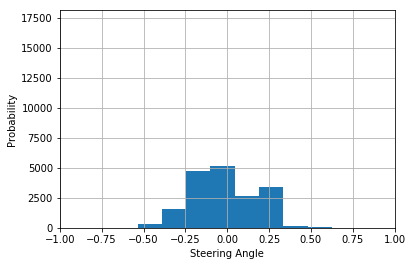

In [17]:
plt.hist(augmented_measurements)
plt.xlabel('Steering Angle')
plt.ylabel('Probability')
plt.axis([-1, 1, 0, len(augmented_measurements)])
plt.grid(True)
plt.show()

In [18]:
# convert to numpy for Keras
## TODO: change back
augmented_images = np.array(augmented_images)
augmented_measurements = np.array(augmented_measurements)

images_val = np.array(images_val)
measurements_val = np.array(measurements_val)

In [19]:

print(augmented_images.shape)
print(augmented_measurements.shape)

print(images_val.shape)
print(measurements_val.shape)

(18134, 160, 320, 3)
(18134,)
(2216, 160, 320, 3)
(2216,)


## Train a Network

# Graph
model = Sequential()

# Data Preprocessing
## normalization -255
## mean centering -0.5 
model.add(Lambda(lambda x: (x/255.0)-0.5, input_shape=(160,320,3)))

# cropping image
model.add(Cropping2D(cropping=((50,20), (0,0))))

#LeNet
model.add(Convolution2D(6,5,5,activation="relu"))
model.add(MaxPooling2D())
model.add(Convolution2D(6,5,5,activation="relu"))
model.add(MaxPooling2D())
model.add(Convolution2D(6,5,5,activation="relu"))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(120))
model.add(Dense(84))
model.add(Dense(1))


# train the model as a regression network
model.compile(loss='mse', optimizer='adam')
history_object = model.fit(augmented_images, augmented_measurements, nb_epoch=5, verbose=1, validation_data=(images_val, measurements_val), shuffle=True)

# save the model for later test on simulator
model.save('model_augmented_brightness.h5')

In [20]:
# Graph
model_nvidia = Sequential()

# Data Preprocessing
## normalization -255
## mean centering -0.5 
model_nvidia.add(Lambda(lambda x: (x/255.0)-0.5, input_shape=(160,320,3)))

# cropping image
model_nvidia.add(Cropping2D(cropping=((65,25), (0,0))))

#nvidia
model_nvidia.add(Convolution2D(24,5,5,subsample=(2,2),activation="relu"))

model_nvidia.add(Convolution2D(36,5,5,subsample=(2,2),activation="relu"))

model_nvidia.add(Convolution2D(48,5,5,subsample=(2,2),activation="relu"))
model_nvidia.add(Convolution2D(64,3,3,activation="relu"))
model_nvidia.add(Convolution2D(64,3,3,activation="relu"))
model_nvidia.add(Flatten())
model_nvidia.add(Dense(100))
model_nvidia.add(Dense(50))
model_nvidia.add(Dense(10))
model_nvidia.add(Dense(1))

# train the model as a regression network
model_nvidia.compile(loss='mse', optimizer='adam')
history_object = model_nvidia.fit(augmented_images, augmented_measurements, nb_epoch=4, verbose=1, validation_data=(images_val, measurements_val), shuffle=True)

# save the model for later test on simulator
model_nvidia.save('model_nvidia.h5')

Train on 18134 samples, validate on 2216 samples
Epoch 1/4
18134/18134 [==============================] - 48s - loss: 0.0218 - val_loss: 0.0201
Epoch 2/4
18134/18134 [==============================] - 44s - loss: 0.0150 - val_loss: 0.0128
Epoch 3/4
18134/18134 [==============================] - 44s - loss: 0.0112 - val_loss: 0.0112
Epoch 4/4
18134/18134 [==============================] - 43s - loss: 0.0081 - val_loss: 0.0110


In [21]:
### print the keys contained in the history object
print(history_object.history.keys())
print("\n")
print(history_object.history['loss'])
print("\n")
print(history_object.history['val_loss'])


dict_keys(['val_loss', 'loss'])


[0.021839805440411253, 0.015031150817374772, 0.011162517965065909, 0.0081383066588370367]


[0.020055394861779919, 0.012788432414915802, 0.011243386970772425, 0.011008387792936194]


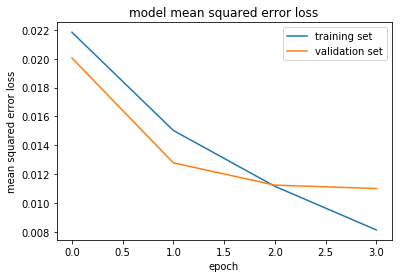

In [22]:
### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])

plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')

plt.show()

## Run drive.py make prediction on my saved model for later used on the simulator

In [2]:
cd D:\OneDrive\Documents\SDCN\Term 1\Behavioral Cloning

D:\OneDrive\Documents\SDCN\Term 1\Behavioral Cloning


In [1]:
%run drive.py model_nvidia.h5

Using TensorFlow backend.


NOT RECORDING THIS RUN ...


(5640) wsgi starting up on http://0.0.0.0:4567
(5640) accepted ('127.0.0.1', 37062)


connect  ca338e9f76504a4cb6bae0c7fcc047c3
-0.19576965272426605 3.06
-0.19576965272426605 3.12
-0.19576965272426605 3.18
-0.13903813064098358 3.2391840000000003
-0.13903813064098358 3.299168
-0.13903813064098358 3.359152
-0.1445014625787735 3.3100266
-0.1445014625787735 3.3678712
-0.1445014625787735 3.4257158
-0.16300681233406067 3.4084782000000002
-0.16300681233406067 3.4648506
-0.16300681233406067 3.521223
-0.09870459884405136 3.4582656000000003
-0.09870459884405136 3.5122982
-0.09870459884405136 3.5663308000000002
-0.11810518056154251 3.5002278000000002
-0.11810518056154251 3.5519048
-0.11810518056154251 3.6035817999999997
-0.12314082682132721 3.5602968000000006
-0.12314082682132721 3.6101118000000003
-0.12314082682132721 3.6599268000000005
-0.1363442838191986 3.6390354000000005
-0.1363442838191986 3.6874640000000003
-0.1363442838191986 3.7358926000000006
-0.08888144791126251 3.6673986000000003
-0.08888144791126251 3.7135346
-0.08888144791126251 3.7596705999999998
-0.0408076606690883

0.0633271262049675 3.0626414
0.0633271262049675 3.0622642
0.0633271262049675 3.0618870000000005
0.12371271103620529 3.0617648000000006
0.12371271103620529 3.061392600000001
0.12371271103620529 3.061020400000001
0.08117224276065826 3.0604850000000012
0.08117224276065826 3.0601096000000014
0.08117224276065826 3.059734200000001
0.15784315764904022 3.0595322000000014
0.15784315764904022 3.0591602000000013
0.15784315764904022 3.0587882000000017
0.0885690301656723 3.0581816000000015
0.0885690301656723 3.0578050000000014
0.0885690301656723 3.0574284000000014
0.05332649126648903 3.0572660000000016
0.05332649126648903 3.0568936000000013
0.05332649126648903 3.056521200000001
0.08269357681274414 3.055893800000001
0.08269357681274414 3.055516400000001
0.08269357681274414 3.0551390000000014
-0.02137468196451664 3.0547412000000014
-0.02137468196451664 3.054363400000001
-0.02137468196451664 3.053985600000001
-0.14683806896209717 3.0536486000000007
-0.14683806896209717 3.053271600000001
-0.14683806896

0.01334055233746767 2.9813524
0.01334055233746767 2.980976
-0.06609983742237091 2.9805791999999998
-0.06609983742237091 2.9802024
-0.06609983742237091 2.9798256
-0.08675114065408707 2.9794283999999998
-0.08675114065408707 2.9790512
-0.08675114065408707 2.9786740000000003
-0.047161299735307693 2.9784804
-0.047161299735307693 2.9781068
-0.047161299735307693 2.9777332000000003
-0.07448917627334595 2.977329
-0.07448917627334595 2.9769548
-0.12667879462242126 2.9764786
-0.14668704569339752 2.9760718
-0.14668704569339752 2.975695
-0.14668704569339752 2.9753182
-0.22532398998737335 2.9751148
-0.22532398998737335 2.9747414
-0.22532398998737335 2.974368
-0.12071756273508072 2.9739946000000006
-0.12071756273508072 2.9736212000000006
-0.12071756273508072 2.9732478000000007
-0.041539281606674194 2.9733130000000005
-0.041539281606674194 2.9723872000000005
-0.041539281606674194 2.972011400000001
-0.06078547239303589 2.9715540000000007
-0.04039262980222702 2.971207200000001
-0.04039262980222702 2.970

0.0008419887162744999 2.90088440000001
0.0008419887162744999 2.9005068000000103
0.0008419887162744999 2.90012920000001
-0.03291008993983269 2.8997822000000104
-0.03291008993983269 2.8994052000000106
-0.03291008993983269 2.8990282000000107
-0.08353303372859955 2.8986410000000107
-0.08353303372859955 2.8982638000000107
-0.08353303372859955 2.8978866000000107
-0.11510395258665085 2.8975400000000104
-0.11510395258665085 2.8971634000000104
-0.11510395258665085 2.8967868000000103
-0.15398043394088745 2.896471400000011
-0.15398043394088745 2.896096000000011
-0.15398043394088745 2.8957206000000113
-0.2355799525976181 2.8954166000000114
-0.2355799525976181 2.8950426000000116
-0.2355799525976181 2.8946686000000117
-0.13921372592449188 2.8944272000000115
-0.13921372592449188 2.894055800000012
-0.13921372592449188 2.8936844000000117
-0.12565505504608154 2.893659800000012
-0.12565505504608154 2.893295200000012
-0.12565505504608154 2.892930600000012
-0.21074213087558746 2.8918418000000123
-0.2107421

-0.06245221942663193 2.8203944000000143
-0.06245221942663193 2.820021400000014
-0.06245221942663193 2.8196484000000144
-0.07977652549743652 2.8191122000000144
-0.07977652549743652 2.818736000000014
-0.07977652549743652 2.818359800000014
-0.1668671816587448 2.817830600000014
-0.1668671816587448 2.817451400000014
-0.1668671816587448 2.8170722000000143
-0.19671082496643066 2.8168868000000145
-0.19671082496643066 2.8165114000000147
-0.19671082496643066 2.8161360000000144
-0.06473509967327118 2.8160360000000146
-0.06473509967327118 2.815666000000015
-0.06473509967327118 2.815296000000015
-0.0625721886754036 2.8148750000000144
-0.0625721886754036 2.8145040000000145
-0.0625721886754036 2.814133000000014
0.006658297032117844 2.8134560000000146
0.006658297032117844 2.8130790000000148
0.006658297032117844 2.812702000000015
0.12701396644115448 2.812365800000015
0.12701396644115448 2.8119896000000146
0.12701396644115448 2.8116134000000144
0.17880862951278687 2.8109312000000144
0.17880862951278687 

-0.04420110583305359 2.7394630000000233
-0.07084844261407852 2.7390958000000234
-0.07084844261407852 2.7387186000000234
-0.07084844261407852 2.7383414000000235
0.012961248867213726 2.738035600000024
0.012961248867213726 2.737659800000024
0.012961248867213726 2.7372840000000243
-0.09526451677083969 2.7369388000000243
-0.09526451677083969 2.7365636000000246
-0.09526451677083969 2.7361884000000245
-0.09416857361793518 2.7357214000000245
-0.09416857361793518 2.7353444000000247
-0.09416857361793518 2.7349674000000244
-0.11475848406553268 2.7347536000000243
-0.11475848406553268 2.7343798000000246
-0.11477205157279968 2.7339754000000247
-0.15121570229530334 2.733550000000025
-0.15121570229530334 2.7331746000000248
-0.15121570229530334 2.732799200000025
-0.11921482533216476 2.7324340000000253
-0.11921482533216476 2.732058800000025
-0.11921482533216476 2.731683600000025
-0.0434722937643528 2.7314104000000254
-0.0434722937643528 2.7310372000000256
-0.0434722937643528 2.7306640000000253
-0.072020

0.025752034038305283 2.6601216000000236
0.025752034038305283 2.6597450000000236
-0.03202762454748154 2.6593684000000235
-0.03202762454748154 2.6589918000000234
-0.03202762454748154 2.6586152000000234
0.016998257488012314 2.6582590000000237
0.016998257488012314 2.657882800000024
0.016998257488012314 2.6575066000000236
0.03979349136352539 2.6571304000000233
0.03979349136352539 2.6567542000000235
0.03979349136352539 2.656378000000023
-0.020419064909219742 2.6559916000000228
-0.020419064909219742 2.655615200000023
-0.020419064909219742 2.655238800000023
0.014948014169931412 2.654882800000023
0.014948014169931412 2.6545068000000223
0.014948014169931412 2.654130800000022
-0.05984920635819435 2.653744600000022
-0.05984920635819435 2.653368400000022
-0.05984920635819435 2.6529922000000217
-0.021013574674725533 2.652595600000021
-0.021013574674725533 2.652219000000021
-0.021013574674725533 2.651842400000021
-0.03776227682828903 2.6515474000000214
-0.03776227682828903 2.6511724000000214
-0.03776

-0.10375293344259262 2.581279000000017
-0.10375293344259262 2.5809074000000174
-0.10306268185377121 2.5802706000000173
-0.10306268185377121 2.5798938000000176
-0.10306268185377121 2.5795170000000174
-0.2457161396741867 2.5791810000000175
-0.2457161396741867 2.5788050000000173
-0.2457161396741867 2.578429000000017
-0.22338642179965973 2.578042800000017
-0.22338642179965973 2.5776666000000166
-0.22338642179965973 2.5772904000000163
-0.23762980103492737 2.577720000000016
-0.23762980103492737 2.5773596000000163
-0.23762980103492737 2.5769992000000164
-0.23040783405303955 2.5760880000000164
-0.23040783405303955 2.5757168000000163
-0.23040783405303955 2.575345600000016
-0.07630188763141632 2.574964200000016
-0.07630188763141632 2.574592800000016
-0.07630188763141632 2.574221400000016
-0.20078444480895996 2.5737276000000158
-0.20078444480895996 2.573353800000016
-0.20078444480895996 2.5729800000000163
-0.14695747196674347 2.5723206000000167
-0.14695747196674347 2.571941200000017
-0.1469574719

0.11853630095720291 2.500646400000016
0.11853630095720291 2.5002696000000157
0.11853630095720291 2.4998928000000156
-0.007986112497746944 2.4994752000000156
-0.007986112497746944 2.499097600000016
-0.007986112497746944 2.498720000000016
0.10032711923122406 2.498893200000017
0.10032711923122406 2.498526400000017
0.10032711923122406 2.498159600000017
0.13847148418426514 2.497272600000017
0.13847148418426514 2.496895600000017
0.13847148418426514 2.4965186000000172
0.15525399148464203 2.4963558000000172
0.15525399148464203 2.4959830000000167
0.15525399148464203 2.4956102000000167
0.13097329437732697 2.495278200000017
0.13097329437732697 2.494906200000017
0.13097329437732697 2.4945342000000172
0.07561929523944855 2.4941214000000174
0.07561929523944855 2.4937486000000173
0.07561929523944855 2.493375800000017
-0.06131327524781227 2.492839800000017
-0.06131327524781227 2.4924638000000168
-0.06131327524781227 2.4920878000000166
0.06870973855257034 2.491620000000016
0.06870973855257034 2.4912422

-0.034687090665102005 2.420881600000022
-0.017089074477553368 2.4204448000000225
-0.017089074477553368 2.4200680000000223
-0.017089074477553368 2.419691200000022
0.07211888581514359 2.4193246000000217
0.07211888581514359 2.4189480000000216
0.07211888581514359 2.4185714000000216
0.20843707025051117 2.418174400000022
0.20843707025051117 2.417797400000022
0.20843707025051117 2.4174204000000223
0.3634375333786011 2.417125000000022
0.3634375333786011 2.4167496000000224
0.3634375333786011 2.4163742000000226
0.32190895080566406 2.4167944000000223
0.32190895080566406 2.416434600000022
0.32190895080566406 2.416074800000022
0.3336288332939148 2.416949200000022
0.3336288332939148 2.4166136000000225
0.3336288332939148 2.4162780000000224
0.2868741750717163 2.4144532000000223
0.2868741750717163 2.4140884000000224
0.2868741750717163 2.4137236000000226
0.27795687317848206 2.413287400000023
0.27795687317848206 2.412921200000023
0.27795687317848206 2.412555000000023
0.3708510100841522 2.411617600000023


-0.05770315229892731 2.3416766000000226
-0.05770315229892731 2.3413010000000227
-0.05770315229892731 2.3409254000000232
-0.10658635944128036 2.340488600000023
-0.10658635944128036 2.340111800000023
-0.10658635944128036 2.339735000000023
-0.10974746197462082 2.339409200000023
-0.10974746197462082 2.3390334000000235
-0.10974746197462082 2.3386576000000234
-0.030235551297664642 2.338373600000024
0.03413867577910423 2.3379996000000243
0.03413867577910423 2.3376256000000244
0.032463353127241135 2.3372006000000245
0.032463353127241135 2.3368256000000245
0.032463353127241135 2.3364506000000245
-0.07990163564682007 2.336096000000024
-0.07990163564682007 2.335721400000024
-0.07990163564682007 2.335346800000024
-0.1432487964630127 2.3348702000000237
-0.1432487964630127 2.3344936000000236
-0.1432487964630127 2.3341170000000235
-0.13849705457687378 2.333883200000024
-0.13849705457687378 2.333784800000024
-0.13849705457687378 2.3334164000000244
-0.13287943601608276 2.332925600000024
-0.132879436016

-0.18015672266483307 2.2627094000000274
-0.18015672266483307 2.262331400000027
-0.10158228129148483 2.261973800000027
-0.10158228129148483 2.261596200000027
-0.10158228129148483 2.2612186000000274
-0.043602362275123596 2.2612388000000276
-0.043602362275123596 2.260869000000028
-0.043602362275123596 2.2601422000000277
-0.009984640404582024 2.2597144000000275
-0.009984640404582024 2.2593366000000272
-0.009984640404582024 2.2589588000000274
-0.09292750060558319 2.258581000000027
-0.09292750060558319 2.2582032000000267
0.06081460416316986 2.2578356000000266
-0.07554780691862106 2.257468200000027
-0.07554780691862106 2.257090800000027
-0.07554780691862106 2.2567134000000273
-0.08041976392269135 2.2564482000000274
-0.08041976392269135 2.2560730000000273
-0.08041976392269135 2.2556978000000276
0.03808409720659256 2.2553226000000275
0.03808409720659256 2.254947400000028
0.03808409720659256 2.2545722000000277
-0.05408359691500664 2.254166400000028
-0.05408359691500664 2.253790600000028
-0.05408

-0.11423925310373306 2.183212600000029
-0.11423925310373306 2.182835600000029
-0.11423925310373306 2.182458600000029
-0.1281386762857437 2.182061200000029
-0.1281386762857437 2.181683800000029
-0.1281386762857437 2.1813064000000293
-0.13996560871601105 2.1810616000000294
-0.13996560871601105 2.180686800000029
-0.13996560871601105 2.180312000000029
-0.15186719596385956 2.1799168000000293
-0.15186719596385956 2.1795416000000296
-0.15186719596385956 2.1791664000000295
-0.05591106414794922 2.1788116000000293
-0.05591106414794922 2.178436800000029
-0.05591106414794922 2.178062000000029
-0.061739664524793625 2.177697400000029
-0.061739664524793625 2.177322800000029
-0.061739664524793625 2.176948200000029
-0.022451655939221382 2.176400200000029
-0.022451655939221382 2.1760222000000287
-0.022451655939221382 2.1756442000000287
-0.024972660467028618 2.1752764000000284
-0.024972660467028618 2.174898600000028
-0.024972660467028618 2.1745208000000282
-0.013858497142791748 2.174163400000028
-0.01385

-0.10089338570833206 2.103888800000033
-0.10089338570833206 2.103512400000033
-0.05077223479747772 2.1032686000000322
-0.05077223479747772 2.1028948000000325
-0.05077223479747772 2.1025210000000327
-0.12128360569477081 2.1020146000000333
-0.12128360569477081 2.101638200000033
-0.12128360569477081 2.101261800000033
-0.17390935122966766 2.100824200000033
-0.17390935122966766 2.100446600000033
-0.17390935122966766 2.1000690000000333
-0.1367340385913849 2.099834200000033
-0.1367340385913849 2.099459400000033
-0.1367340385913849 2.099084600000033
-0.13338232040405273 2.0989036000000327
-0.13338232040405273 2.098532600000033
-0.13338232040405273 2.0981616000000325
-0.014737286604940891 2.0975254000000327
-0.014737286604940891 2.097149200000033
-0.014737286604940891 2.0967730000000326
-0.04580282047390938 2.0963866000000326
-0.04580282047390938 2.0960102000000322
-0.04580282047390938 2.0956338000000323
0.10480787605047226 2.095216600000032
0.10480787605047226 2.094839400000032
0.1048078760504

-0.012997174635529518 2.0250008000000275
0.15625621378421783 2.024684600000028
0.15625621378421783 2.024308400000028
0.15625621378421783 2.023932200000028
0.14606815576553345 2.0234948000000275
0.14606815576553345 2.0231174000000274
0.14606815576553345 2.0227400000000277
0.12328768521547318 2.023066400000028
0.12328768521547318 2.022702800000028
0.12328768521547318 2.0223392000000278
0.13044168055057526 2.0215370000000283
0.13044168055057526 2.021164800000028
0.13044168055057526 2.020792600000028
0.07408760488033295 2.020247000000028
0.07408760488033295 2.0198714000000275
0.07408760488033295 2.0194958000000276
0.07979059964418411 2.0191202000000277
0.07979059964418411 2.0187446000000273
0.07979059964418411 2.0183690000000274
0.002869039075449109 2.0178812000000277
0.002869039075449109 2.017503400000028
0.002869039075449109 2.0171256000000275
-0.09669683873653412 2.016768200000027
-0.09669683873653412 2.016390800000027
-0.09669683873653412 2.016095000000027
-0.09252295643091202 2.015668

-0.019317159429192543 1.9440922000000291
-0.16556109488010406 1.9438264000000292
-0.16556109488010406 1.9434506000000291
-0.16556109488010406 1.943074800000029
-0.18815959990024567 1.9426786000000293
-0.18815959990024567 1.9423024000000293
-0.18815959990024567 1.9419262000000295
-0.08048530668020248 1.942233400000029
-0.08048530668020248 1.941870600000029
-0.08048530668020248 1.9415078000000288
-0.13016831874847412 1.940920600000029
-0.13016831874847412 1.940553400000029
-0.13016831874847412 1.9401862000000292
-0.04604882374405861 1.939309000000029
-0.04604882374405861 1.9389318000000293
-0.04604882374405861 1.9385546000000293
-0.15473145246505737 1.9382692000000297
-0.15473145246505737 1.9378938000000296
-0.15473145246505737 1.9375184000000298
-0.14966769516468048 1.9370104000000299
-0.14966769516468048 1.93663240000003
-0.14966769516468048 1.9362544000000301
-0.07998068630695343 1.9361620000000301
-0.07998068630695343 1.93578960000003
-0.07998068630695343 1.9354172000000303
0.0177004

-0.07690995186567307 1.8647964000000319
-0.04145080968737602 1.8645316000000318
-0.04145080968737602 1.864156800000032
-0.04145080968737602 1.8637820000000318
-0.06419038772583008 1.8632848000000317
-0.06419038772583008 1.862907600000032
-0.06419038772583008 1.862530400000032
-0.12491241842508316 1.862153200000032
-0.12491241842508316 1.8617760000000323
-0.12491241842508316 1.8613988000000323
0.014025384560227394 1.8610318000000323
0.014025384560227394 1.8606548000000325
0.014025384560227394 1.8602778000000324
-0.011229895055294037 1.8600640000000324
-0.011229895055294037 1.8596902000000324
-0.011229895055294037 1.8593164000000322
0.08741836994886398 1.8588304000000324
0.08741836994886398 1.8584544000000325
0.08741836994886398 1.8580784000000325
-0.0029676512349396944 1.8576310000000322
-0.0029676512349396944 1.8572536000000321
-0.0029676512349396944 1.856876200000032
-0.019968533888459206 1.856733400000032
-0.019968533888459206 1.856360600000032
-0.019968533888459206 1.855987800000031

-0.11706661432981491 1.7862002000000337
-0.11706661432981491 1.7858226000000335
-0.1603798270225525 1.7859856000000338
-0.1603798270225525 1.7856186000000338
-0.1603798270225525 1.7852516000000338
-0.08131562173366547 1.7845480000000336
-0.08131562173366547 1.7841744000000337
-0.08131562173366547 1.7838008000000336
-0.1810278296470642 1.7834170000000338
-0.1810278296470642 1.7830432000000338
-0.1810278296470642 1.7826694000000336
-0.19868798553943634 1.7820406000000337
-0.19868798553943634 1.781661800000034
-0.19868798553943634 1.781283000000034
-0.1449098289012909 1.7813020000000337
-0.1449098289012909 1.7809310000000336
-0.1449098289012909 1.7805600000000334
-0.0852966159582138 1.7801278000000336
-0.0852966159582138 1.7797556000000336
-0.0852966159582138 1.7793834000000335
-0.03579350560903549 1.7787256000000335
-0.03579350560903549 1.7783478000000335
-0.03579350560903549 1.7779700000000336
0.03875235095620155 1.7776024000000334
0.07503435015678406 1.7772248000000335
0.07503435015678

-0.16825541853904724 1.707688800000033
-0.16825541853904724 1.707331000000033
-0.16825541853904724 1.706973200000033
-0.1823311150074005 1.7059830000000331
-0.1823311150074005 1.705612800000033
-0.1823311150074005 1.705242600000033
-0.11492059379816055 1.7045460000000325
-0.11492059379816055 1.7041694000000325
-0.11492059379816055 1.7037928000000324
-0.08843538910150528 1.7034774000000328
-0.08843538910150528 1.703102000000033
-0.08843538910150528 1.702726600000033
-0.04886608198285103 1.702177800000033
-0.04886608198285103 1.7017990000000331
-0.04886608198285103 1.7014202000000331
-0.1275012046098709 1.701061800000033
-0.1275012046098709 1.7006834000000328
-0.1275012046098709 1.7003050000000328
-0.1302679479122162 1.699947000000033
-0.1302679479122162 1.6995690000000332
-0.1302679479122162 1.6991910000000332
-0.17086154222488403 1.698966000000033
-0.17086154222488403 1.698591000000033
-0.17086154222488403 1.698216000000033
-0.14625148475170135 1.6977696000000333
-0.14625148475170135 1

0.08037316054105759 1.6272844000000342
0.08037316054105759 1.6269074000000343
0.06302159279584885 1.6265610000000343
0.06302159279584885 1.6261846000000342
0.06302159279584885 1.6258082000000342
0.06141386181116104 1.6254930000000343
0.06141386181116104 1.6251178000000341
0.06141386181116104 1.6247426000000342
0.0506569929420948 1.624296000000034
0.0506569929420948 1.6239194000000339
0.0506569929420948 1.6235326000000339
0.11208777874708176 1.623155800000034
0.11208777874708176 1.622779000000034
0.11208777874708176 1.6224022000000338
0.0916910171508789 1.6220050000000341
0.0916910171508789 1.6216278000000341
0.0916910171508789 1.6212506000000342
0.07345425337553024 1.6210162000000343
0.07345425337553024 1.6206418000000344
0.07345425337553024 1.6202674000000346
0.003541976911947131 1.6197910000000346
0.003541976911947131 1.6194146000000345
0.003541976911947131 1.6190382000000345
-0.07152840495109558 1.6186210000000343
-0.07152840495109558 1.6182438000000343
-0.07152840495109558 1.617866

-0.014808462001383305 1.5481128000000344
-0.014808462001383305 1.5477366000000345
0.008780242875218391 1.5473502000000343
0.008780242875218391 1.5469738000000341
0.008780242875218391 1.5465974000000342
-0.0015045099426060915 1.5462312000000342
-0.0015045099426060915 1.5458550000000344
-0.0015045099426060915 1.5454788000000343
-0.0029106643050909042 1.5450924000000343
-0.0029106643050909042 1.5447160000000342
-0.0029106643050909042 1.544339600000034
0.0024661512579768896 1.5439632000000338
0.0024661512579768896 1.543586800000034
0.0024661512579768896 1.5432104000000337
0.030676372349262238 1.5428238000000334
0.030676372349262238 1.5424472000000333
0.030676372349262238 1.5420706000000333
0.04126298800110817 1.5417042000000334
0.04126298800110817 1.5413278000000334
0.04126298800110817 1.5409514000000333
0.026655104011297226 1.5405954000000333
0.026655104011297226 1.540219400000033
0.026655104011297226 1.5398434000000332
-0.025369547307491302 1.5394674000000332
-0.025369547307491302 1.5390

-0.08968576043844223 1.4835140000000309
-0.08968576043844223 1.4834560000000308
-0.08968576043844223 1.4833980000000309
-0.11875421553850174 1.4664182000000308
-0.11875421553850174 1.466028400000031
-0.11875421553850174 1.465638600000031
-0.14016273617744446 1.464708200000031
-0.14016273617744446 1.4643078000000311
-0.14016273617744446 1.4639074000000312
-0.13014107942581177 1.4650166000000309
-0.13014107942581177 1.4646458000000309
-0.13014107942581177 1.464275000000031
-0.18488463759422302 1.4639552000000313
-0.18488463759422302 1.4635854000000315
-0.18488463759422302 1.4632156000000316
-0.21678796410560608 1.4625704000000315
-0.21678796410560608 1.4621952000000316
-0.21678796410560608 1.4618200000000316
-0.2194928526878357 1.4616182000000315
-0.2194928526878357 1.4612464000000316
-0.2194928526878357 1.4608746000000317
-0.18748348951339722 1.460594600000032
-0.18748348951339722 1.460224600000032
-0.18748348951339722 1.4598546000000323
-0.16530297696590424 1.4593826000000323
-0.165302

-0.21333961188793182 1.3882956000000317
-0.21333961188793182 1.3879224000000316
-0.40487444400787354 1.3875288000000314
-0.40487444400787354 1.3871552000000316
-0.40487444400787354 1.3867816000000317
-0.38401228189468384 1.385989800000032
-0.38401228189468384 1.385608000000032
-0.38401228189468384 1.3852262000000317
-0.29480427503585815 1.3866294000000314
-0.29480427503585815 1.3862826000000315
-0.29480427503585815 1.3859358000000315
-0.11002127081155777 1.3848138000000314
-0.11002127081155777 1.3844518000000314
-0.11002127081155777 1.3840898000000312
-0.16944918036460876 1.3829934000000312
-0.16944918036460876 1.3826170000000313
-0.16944918036460876 1.3822406000000311
-0.018952324986457825 1.381548000000031
-0.018952324986457825 1.3811654000000313
-0.018952324986457825 1.3807828000000313
-0.08754897862672806 1.380614400000031
-0.08754897862672806 1.380236000000031
-0.08754897862672806 1.379857600000031
0.005345395766198635 1.379550600000031
0.005345395766198635 1.3791736000000312
0.00

-0.18452252447605133 1.3096626000000335
-0.18452252447605133 1.3092900000000336
-0.10429870337247849 1.3090194000000335
-0.10429870337247849 1.3086488000000334
-0.10429870337247849 1.3082782000000335
-0.1628245711326599 1.3083258000000335
-0.1628245711326599 1.3079634000000335
-0.1628245711326599 1.3076010000000335
-0.17136560380458832 1.3065450000000338
-0.17136560380458832 1.3061690000000339
-0.17136560380458832 1.3057930000000337
-0.08943326771259308 1.305590400000034
-0.08943326771259308 1.305217800000034
-0.08943326771259308 1.3048452000000341
-0.07568390667438507 1.3044318000000343
-0.07568390667438507 1.3040584000000344
-0.07568390667438507 1.3036850000000344
-0.1233893409371376 1.3030770000000342
-0.1233893409371376 1.3026990000000345
-0.1233893409371376 1.3023210000000345
-0.16669213771820068 1.3019532000000342
-0.16669213771820068 1.3015754000000344
-0.16669213771820068 1.3011976000000343
-0.1099795550107956 1.3009218000000344
-0.1099795550107956 1.3005460000000346
-0.1099795

-0.013792108744382858 1.230366800000034
-0.013792108744382858 1.229988600000034
-0.013792108744382858 1.2296104000000339
-0.04390142112970352 1.2292628000000339
-0.04390142112970352 1.2288852000000337
-0.04390142112970352 1.2285076000000337
0.03270138055086136 1.2281606000000338
0.03270138055086136 1.2277836000000337
0.03270138055086136 1.2274066000000339
0.06591115891933441 1.2270500000000337
0.06591115891933441 1.2266734000000337
0.06591115891933441 1.2262968000000336
0.1237596645951271 1.2259100000000336
0.1237596645951271 1.2255332000000334
0.1237596645951271 1.2251564000000335
0.07443846762180328 1.224810200000034
0.07443846762180328 1.224434000000034
0.07443846762180328 1.2240578000000342
0.2026441991329193 1.2237530000000338
0.2026441991329193 1.2233782000000337
0.2026441991329193 1.2230034000000338
0.1110491082072258 1.2224960000000336
0.1110491082072258 1.2221186000000335
0.1110491082072258 1.2217412000000334
0.18478892743587494 1.2217208000000337
0.18478892743587494 1.2213504

-0.1865515112876892 1.149849200000034
-0.1089087501168251 1.149301800000034
-0.1089087501168251 1.1489244000000338
-0.1089087501168251 1.1485470000000337
-0.09473223239183426 1.1486796000000334
-0.09473223239183426 1.1483122000000334
-0.09473223239183426 1.1479448000000334
-0.08426941931247711 1.1469450000000336
-0.08426941931247711 1.1465652000000337
-0.08426941931247711 1.1461854000000338
0.014694930985569954 1.1459076000000337
0.014694930985569954 1.1455298000000338
0.014694930985569954 1.1451520000000337
-0.1863926351070404 1.1448354000000336
-0.1863926351070404 1.1444588000000335
-0.1863926351070404 1.1440822000000335
-0.13256514072418213 1.1437158000000338
-0.13256514072418213 1.1433394000000336
-0.13256514072418213 1.1429630000000335
-0.2850393056869507 1.1430966000000333
-0.2850393056869507 1.1427302000000334
-0.2850393056869507 1.1423638000000336
-0.2972396910190582 1.1415180000000336
-0.2972396910190582 1.1411422000000335
-0.2972396910190582 1.1407664000000335
-0.320569664239

-0.07468674331903458 1.072482600000033
-0.07468674331903458 1.071825600000033
-0.11446572095155716 1.071418000000033
-0.11446572095155716 1.0710404000000329
-0.11446572095155716 1.0706628000000329
-0.06541133671998978 1.0702954000000326
-0.06541133671998978 1.0699180000000326
-0.06541133671998978 1.0695406000000325
-0.08181951195001602 1.069265200000033
-0.08181951195001602 1.0688898000000329
-0.08181951195001602 1.068514400000033
-0.006994414143264294 1.068026800000033
-0.006994414143264294 1.0676492000000328
-0.006994414143264294 1.0672716000000328
-0.008932916447520256 1.066924600000033
-0.008932916447520256 1.066547600000033
-0.008932916447520256 1.066170600000033
0.020560473203659058 1.065793600000033
0.020560473203659058 1.0654166000000331
0.020560473203659058 1.065039600000033
-0.06060028076171875 1.0646422000000328
-0.06060028076171875 1.0642648000000328
-0.06060028076171875 1.0638874000000327
-0.06957746297121048 1.0635406000000327
-0.06957746297121048 1.0631638000000327
-0.06

-0.06580286473035812 0.9925682000000323
-0.036415018141269684 0.9922552000000324
-0.036415018141269684 0.9918822000000325
-0.036415018141269684 0.9915092000000325
-0.051118314266204834 0.9910954000000323
-0.051118314266204834 0.9907216000000323
-0.051118314266204834 0.9903478000000323
0.03429698199033737 0.9900250000000325
0.03429698199033737 0.9896522000000326
0.03429698199033737 0.9892794000000326
0.02844594605267048 0.9889270000000324
0.02844594605267048 0.9885546000000326
0.02844594605267048 0.9881822000000325
0.151951402425766 0.9878914000000324
0.151951402425766 0.9875206000000324
0.151951402425766 0.9871498000000324
0.055657804012298584 0.9867790000000324
0.055657804012298584 0.9864082000000322
0.055657804012298584 0.9860374000000321
0.0794956311583519 0.9860542000000323
0.0794956311583519 0.9856910000000323
0.0794956311583519 0.9853278000000323
0.01879691146314144 0.9846076000000326
0.01879691146314144 0.9842374000000327
0.01879691146314144 0.9838672000000326


127.0.0.1 - - [14/Jan/2018 22:36:21] "GET /socket.io/?EIO=4&transport=websocket HTTP/1.1" 200 0 218.088675
wsgi exiting
(5640) wsgi exited, is_accepting=True


In [3]:
%run drive.py model.h5

Using TensorFlow backend.


NOT RECORDING THIS RUN ...


(18136) wsgi starting up on http://0.0.0.0:4567
(18136) accepted ('127.0.0.1', 36069)


connect  630cecff654c4148b66aff42a8143591
-0.20623928308486938 2.9706479999999997
-0.20623928308486938 2.939544
-0.20623928308486938 2.9960400000000003
-0.1911924183368683 3.231189
-0.1911924183368683 3.2716754
-0.1911924183368683 3.3312918000000002
-0.17070606350898743 3.3187228
-0.17070606350898743 3.3769238
-0.17070606350898743 3.4351248
-0.16354599595069885 3.3990574000000002
-0.16354599595069885 3.4554100000000005
-0.16354599595069885 3.511762600000001
-0.15603001415729523 3.4541506000000006
-0.15603001415729523 3.5082686000000005
-0.15603001415729523 3.562386600000001
-0.1716785430908203 3.5204920000000004
-0.1716785430908203 3.5727274000000007
-0.1716785430908203 3.6249628000000005
-0.1095026433467865 3.5820322000000004
-0.1095026433467865 3.6324016000000006
-0.1095026433467865 3.6827710000000007
-0.1264440268278122 3.6388006000000006
-0.1264440268278122 3.687320200000001
-0.1264440268278122 3.735839800000001
-0.08658099174499512 3.7139386000000014
-0.08658099174499512 3.7610774

(18136) accepted ('127.0.0.1', 36555)


connect  0726d699d4374a869caf5da6d84fae4f
-0.1918344646692276 6.297466600000002
-0.1918344646692276 6.357466600000002
-0.1918344646692276 6.417466600000003
-0.19179612398147583 6.432790600000002
-0.19179612398147583 6.491914600000002
-0.2263578325510025 6.461686600000002
-0.24248933792114258 6.429706600000001
-0.24248933792114258 6.485326600000001
-0.24248933792114258 6.540946600000002
-0.2164730280637741 6.417862600000001
-0.2164730280637741 6.469978600000001
-0.2164730280637741 6.432742600000001
-0.21950845420360565 6.393754600000001
-0.21950845420360565 6.4423666000000015
-0.21950845420360565 6.490978600000002
-0.17283524572849274 6.316220800000002
-0.17283524572849274 6.3604530000000015
-0.17283524572849274 6.404685200000001
-0.1088971421122551 6.648959800000002
-0.1088971421122551 6.697114400000002
-0.1088971421122551 6.745269000000002
-0.14623244106769562 7.159919800000003
-0.14623244106769562 7.215260600000002
-0.14623244106769562 7.270601400000002
-0.11334794014692307 7.2878044

-0.004567902535200119 7.628078200000003
-0.005978336092084646 7.627701000000003
-0.005978336092084646 7.627323800000003
-0.005978336092084646 7.626946600000003
0.014140754006803036 7.626569400000003
0.014140754006803036 7.626192200000003
0.014140754006803036 7.625815000000003
-0.049565330147743225 7.625437800000003
-0.049565330147743225 7.625060600000003
-0.049565330147743225 7.624683400000003
-0.01934964582324028 7.624316400000002
-0.01934964582324028 7.623939400000002
-0.01934964582324028 7.623562400000002
-0.011786418966948986 7.623226200000002
-0.011786418966948986 7.622850000000002
-0.011786418966948986 7.6224738000000025
-0.03904464840888977 7.622046600000003
-0.03904464840888977 7.621669400000003
-0.03904464840888977 7.621292200000004
0.010379896499216557 7.620915000000004
0.010379896499216557 7.620537800000004
0.010379896499216557 7.620160600000004
0.016218658536672592 7.619803800000003
0.016218658536672592 7.6194270000000035
0.016218658536672592 7.619050200000004
-0.0112927658

-0.028823446482419968 7.545982999999995
-0.028823446482419968 7.545605799999995
0.014272917993366718 7.545228599999995
0.014272917993366718 7.544851399999995
0.014272917993366718 7.544474199999995
-0.03365563228726387 7.544147999999996
-0.03365563228726387 7.5437717999999965
-0.03365563228726387 7.543395599999997
-0.010566205717623234 7.542978599999996
-0.010566205717623234 7.542601599999996
-0.010566205717623234 7.542224599999995
-0.029299385845661163 7.541867999999996
-0.029299385845661163 7.541491399999996
-0.029299385845661163 7.541114799999996
-0.10745915025472641 7.540687199999996
-0.10745915025472641 7.540340199999996
-0.10745915025472641 7.539963199999995
-0.10101114213466644 7.539586199999995
-0.10801634937524796 7.539525399999996
-0.10801634937524796 7.539154599999996
-0.10801634937524796 7.5387837999999965
-0.033351797610521317 7.538198799999996
-0.033351797610521317 7.537823799999996
-0.033351797610521317 7.537448799999996
0.01427133847028017 7.537063599999996
0.01427133847

0.041791871190071106 7.464120999999997
0.041791871190071106 7.463744399999998
0.041791871190071106 7.463367799999998
0.053921572864055634 7.462960599999998
0.053921572864055634 7.462583399999998
0.053921572864055634 7.462206199999998
0.017268333584070206 7.461869799999999
0.017268333584070206 7.461493399999998
0.017268333584070206 7.461116999999998
0.04390151426196098 7.460730399999998
0.04390151426196098 7.460353799999998
0.04390151426196098 7.459977199999999
-0.03407107666134834 7.459569999999999
-0.03407107666134834 7.459192799999999
-0.03407107666134834 7.458815599999999
-0.09030865877866745 7.4584588
-0.09030865877866745 7.4581228
-0.09030865877866745 7.4577468
-0.07650443911552429 7.4573605999999995
-0.10323651880025864 7.457249599999999
-0.10323651880025864 7.4568786
-0.10323651880025864 7.456507599999999
-0.08250854909420013 7.455912199999999
-0.08250854909420013 7.4555368
-0.08250854909420013 7.4551614
-0.05237586423754692 7.4548064
-0.05237586423754692 7.4544314
-0.0523758642

-0.05084749683737755 7.384517799999995
-0.05084749683737755 7.384140399999994
-0.05084749683737755 7.383762999999994
-0.13491341471672058 7.383507999999994
-0.13491341471672058 7.383132999999994
-0.13491341471672058 7.382757999999994
-0.1970853954553604 7.382311599999993
-0.1970853954553604 7.381935199999994
-0.1970853954553604 7.381558799999993
-0.19758340716362 7.381284399999993
-0.19758340716362 7.380909999999994
-0.19758340716362 7.380535599999994
-0.17688071727752686 7.380446799999994
-0.17688071727752686 7.380077999999994
-0.17688071727752686 7.3797091999999935
-0.07773305475711823 7.379177199999993
-0.07773305475711823 7.378805199999993
-0.07773305475711823 7.378433199999993
-0.1621711105108261 7.377887799999993
-0.1621711105108261 7.377512399999993
-0.1621711105108261 7.377136999999993
-0.1925937980413437 7.376598399999993
-0.1925937980413437 7.376219799999993
-0.1925937980413437 7.375841199999993
-0.28522300720214844 7.375697199999993
-0.28522300720214844 7.375323199999993
-0.

-0.02833179011940956 7.30334219999999
-0.02833179011940956 7.30296499999999
-0.02833179011940956 7.30258779999999
0.006251227110624313 7.30233299999999
0.006251227110624313 7.301958199999991
0.006251227110624313 7.301583399999991
0.018223769962787628 7.301075999999991
0.018223769962787628 7.300698599999991
0.018223769962787628 7.300321199999991
0.10363376885652542 7.299964199999989
0.10363376885652542 7.299587199999989
0.10436033457517624 7.29922039999999
0.007004545070230961 7.298833399999989
0.007004545070230961 7.2984563999999885
0.007004545070230961 7.298079399999988
-0.01503447350114584 7.297926799999988
-0.01503447350114584 7.297554199999989
-0.01503447350114584 7.297181599999989
0.015024748630821705 7.2965845999999885
0.015024748630821705 7.296207599999988
0.015024748630821705 7.295830599999988
0.03789392486214638 7.295463799999988
0.03789392486214638 7.295086999999988
0.03041335567831993 7.294699999999987
0.029568497091531754 7.294333199999987
0.029568497091531754 7.29395639999

0.06610839813947678 7.222016199999995
0.06610839813947678 7.221639799999996
0.06610839813947678 7.221263399999995
0.042571667581796646 7.220876799999995
0.042571667581796646 7.220500199999996
0.042571667581796646 7.220123599999996
0.07703448086977005 7.219910199999996
0.07703448086977005 7.219536799999996
0.07703448086977005 7.219163399999995
0.08652419596910477 7.218657399999995
0.08652419596910477 7.218281399999995
0.08652419596910477 7.217905399999995
-0.010149477049708366 7.217590599999995
-0.010149477049708366 7.2172157999999955
-0.010149477049708366 7.216840999999995
-0.029574770480394363 7.2164559999999955
-0.029574770480394363 7.2160809999999955
-0.029574770480394363 7.2157059999999955
-0.0623445026576519 7.2152799999999955
-0.0623445026576519 7.214903999999995
-0.0623445026576519 7.214527999999995
-0.0936170294880867 7.214162199999995
-0.0936170294880867 7.213786399999996
-0.0936170294880867 7.213410599999996
-0.08432982861995697 7.2130857999999956
-0.08432982861995697 7.21271

0.06342475861310959 7.140396000000001
0.06342475861310959 7.140020400000001
0.06342475861310959 7.1396448
0.08871941268444061 7.1393712
0.08871941268444061 7.138997600000001
0.08871941268444061 7.138624
0.10189604759216309 7.1380668
0.10189604759216309 7.137689600000001
0.10189604759216309 7.137312400000001
0.04609418660402298 7.1369658000000005
0.04609418660402298 7.136589200000001
0.04609418660402298 7.136212600000001
0.03796303644776344 7.135866600000002
0.03796303644776344 7.135490600000002
0.03796303644776344 7.135114600000001
0.03114476427435875 7.134657000000001
0.03114476427435875 7.134279400000001
0.03114476427435875 7.133901800000001
-0.0775606781244278 7.133534400000002
-0.0775606781244278 7.1331570000000015
-0.0775606781244278 7.132779600000001
-0.03194470703601837 7.1324022000000005
-0.03194470703601837 7.132024800000001
-0.03194470703601837 7.1316474
-0.15157611668109894 7.1314434
-0.15157611668109894 7.1310694
-0.15157611668109894 7.1306954000000005
-0.11605986207723618 

-0.0712500587105751 7.056937800000008
-0.0712500587105751 7.056559000000007
-0.08961202949285507 7.056088400000007
-0.08961202949285507 7.055707800000007
-0.08961202949285507 7.055327200000006
-0.06388557702302933 7.055395400000006
-0.06388557702302933 7.055023600000006
-0.06388557702302933 7.0546518000000065
0.0024067028425633907 7.054188200000007
0.0024067028425633907 7.053814600000007
0.0024067028425633907 7.0534410000000065
-0.18112899363040924 7.0529450000000065
-0.18112899363040924 7.052569000000006
-0.18112899363040924 7.052193000000006
-0.14474400877952576 7.051776200000006
-0.14474400877952576 7.051399400000006
-0.14474400877952576 7.051022600000006
-0.19450463354587555 7.051247600000006
-0.19450463354587555 7.050882600000007
-0.19450463354587555 7.050517600000006
-0.13922850787639618 7.049683400000006
-0.13922850787639618 7.049309200000006
-0.13922850787639618 7.0489350000000055
-0.16430285573005676 7.048754600000007
-0.16430285573005676 7.048384200000007
-0.16430285573005676

0.009551111608743668 6.977003800000001
0.009551111608743668 6.9766270000000015
0.009551111608743668 6.976250200000002
-0.01475796289741993 6.975853000000002
-0.01475796289741993 6.975475800000002
-0.01475796289741993 6.975098600000002
0.09184779226779938 6.974721400000002
0.09184779226779938 6.974344200000002
0.09184779226779938 6.973967000000002
0.060809485614299774 6.973559200000002
0.060809485614299774 6.973181400000002
0.060809485614299774 6.9728036000000015
0.08492112159729004 6.972640000000002
0.08492112159729004 6.972266400000002
0.08492112159729004 6.971892800000002
0.09138215333223343 6.971366200000002
0.09138215333223343 6.970989600000002
0.09138215333223343 6.970613000000003
0.17497630417346954 6.9702772000000035
0.17497630417346954 6.969901400000003
0.17497630417346954 6.969525600000003
0.10759995877742767 6.969139600000004
0.10759995877742767 6.9687636000000035
0.10759995877742767 6.968387600000003
0.08546250313520432 6.9682768000000035
0.08546250313520432 6.96790600000000

0.008315821178257465 6.894307000000005
0.03349023684859276 6.893889600000005
0.03349023684859276 6.893512200000005
0.03349023684859276 6.893134800000005
-0.04234202206134796 6.892767600000004
-0.04234202206134796 6.8923904000000045
-0.04234202206134796 6.8920132000000045
-0.008632584474980831 6.8916360000000045
-0.008632584474980831 6.891258800000005
-0.008632584474980831 6.890881600000005
0.034869201481342316 6.890575800000005
0.034869201481342316 6.890200000000005
0.034869201481342316 6.889824200000006
0.0682014748454094 6.889377000000006
0.0682014748454094 6.889040600000006
0.0682014748454094 6.888664200000005
0.07047849148511887 6.888298000000005
-0.05383823439478874 6.887962600000006
-0.05383823439478874 6.887587200000006
-0.05383823439478874 6.887211800000006
-0.11248096823692322 6.8868058000000065
-0.11248096823692322 6.886429800000006
-0.11248096823692322 6.886053800000005
-0.10918710380792618 6.885749200000006
-0.10918710380792618 6.885374600000006
-0.10918710380792618 6.88500

0.010473199188709259 6.815104200000001
0.010473199188709259 6.814726400000001
0.010473199188709259 6.814348600000001
0.0734601616859436 6.813940200000001
0.0734601616859436 6.813561800000002
0.0734601616859436 6.813183400000002
-0.002357036340981722 6.812886600000002
-0.002357036340981722 6.812509800000002
-0.002357036340981722 6.812133000000002
0.043662261217832565 6.811950000000002
0.043662261217832565 6.811577000000002
0.043662261217832565 6.811204000000003
0.0384310707449913 6.810678000000003
0.0384310707449913 6.810302000000003
0.0384310707449913 6.809926000000003
-0.06118781119585037 6.809488800000002
-0.06118781119585037 6.809111600000002
-0.06118781119585037 6.808734400000002
-0.03990122303366661 6.808326600000003
-0.03990122303366661 6.807948800000003
-0.03990122303366661 6.807571000000002
-0.07189397513866425 6.8074584000000025
-0.07189397513866425 6.807085800000003
-0.07189397513866425 6.8067132000000035
-0.22875238955020905 6.806034600000003
-0.22875238955020905 6.805656000

0.043286677449941635 6.732204799999991
0.031090404838323593 6.731687999999991
0.031090404838323593 6.7313111999999915
0.031090404838323593 6.730934399999991
-0.0753999650478363 6.7305269999999915
-0.0753999650478363 6.730149599999991
-0.0753999650478363 6.72977219999999
-0.1850670874118805 6.72939479999999
-0.1850670874118805 6.72901739999999
-0.1850670874118805 6.72863999999999
-0.13651268184185028 6.728446199999989
-0.13651268184185028 6.728072399999989
-0.13651268184185028 6.7276985999999885
-0.0977666825056076 6.727712399999988
-0.0977666825056076 6.727346199999988
-0.0977666825056076 6.726979999999988
-0.14875218272209167 6.7261547999999864
-0.14875218272209167 6.725779599999986
-0.14875218272209167 6.725404399999986
-0.16055813431739807 6.724916999999986
-0.16055813431739807 6.724539599999986
-0.16055813431739807 6.724162199999985
-0.19811378419399261 6.723947999999985
-0.19811378419399261 6.7235737999999845
-0.19811378419399261 6.723199599999984
-0.1542425900697708 6.72282539999

-0.07095757126808167 6.652894199999983
-0.07095757126808167 6.6525175999999835
-0.07095757126808167 6.652140999999984
-0.0036308299750089645 6.651743999999983
-0.0036308299750089645 6.651366999999983
-0.0036308299750089645 6.650989999999982
-0.05629563331604004 6.650694599999984
-0.05629563331604004 6.650319199999983
-0.05629563331604004 6.649943799999983
0.08739963173866272 6.649476599999983
0.08739963173866272 6.649099399999983
0.08739963173866272 6.648722199999984
0.02591143548488617 6.648385799999984
0.02591143548488617 6.648009399999983
0.02591143548488617 6.647632999999983
-0.021582890301942825 6.647460599999983
-0.021582890301942825 6.647088199999983
-0.021582890301942825 6.646715799999982
-0.05892857909202576 6.646098599999982
-0.05892857909202576 6.6457213999999825
-0.05892857909202576 6.6453441999999825
-0.0763174369931221 6.644987399999983
-0.0763174369931221 6.644610599999983
-0.0763174369931221 6.644233799999983
-0.058992620557546616 6.643907999999983
-0.058992620557546616

-0.040363747626543045 6.573549399999983
-0.040363747626543045 6.573172799999984
-0.040363747626543045 6.572796199999984
0.023252028971910477 6.572388999999984
0.023252028971910477 6.572011799999984
0.023252028971910477 6.571634599999984
-0.054215382784605026 6.571298199999985
-0.054215382784605026 6.570921799999985
-0.054215382784605026 6.570545399999984
0.0674961507320404 6.5701485999999845
0.0674961507320404 6.569771799999985
0.0674961507320404 6.569394999999984
0.09687277674674988 6.569069199999984
0.09687277674674988 6.568693399999985
0.09687277674674988 6.568317599999985
0.10523564368486404 6.568002999999985
0.10523564368486404 6.567628399999985
0.10523564368486404 6.567253799999985
0.040354300290346146 6.566909799999985
0.040354300290346146 6.566535799999985
0.040354300290346146 6.5661617999999855
0.025180287659168243 6.565746999999986
0.025180287659168243 6.5653721999999854
0.025180287659168243 6.564997399999986
-0.02916017919778824 6.564489999999987
-0.02916017919778824 6.56411

-0.007952684536576271 6.492300999999976
-0.007952684536576271 6.491924199999976
-0.007952684536576271 6.491547399999976
-0.031042959541082382 6.491150199999976
-0.031042959541082382 6.490772999999976
-0.031042959541082382 6.490395799999976
0.01418082881718874 6.490018599999976
0.01418082881718874 6.489641399999977
0.01418082881718874 6.489264199999977
0.03415173664689064 6.488897199999975
0.03415173664689064 6.488520199999975
0.03415173664689064 6.488143199999975
0.03381083905696869 6.4877661999999745
0.03381083905696869 6.487389199999974
0.03381083905696869 6.487012199999974
0.028230242431163788 6.486655599999974
0.028230242431163788 6.486278999999975
0.028230242431163788 6.485902399999975
0.06709972769021988 6.485505399999974
0.06709972769021988 6.485128399999974
0.06709972769021988 6.484751399999974
-0.0842309296131134 6.484364199999974
-0.0842309296131134 6.483986999999974
-0.0842309296131134 6.483609799999974
-0.01816149801015854 6.483283599999974
-0.01816149801015854 6.4829073999

0.011726091615855694 6.411739999999975
0.011726091615855694 6.411362799999975
-0.007958080619573593 6.4109957999999745
-0.007958080619573593 6.410618799999974
-0.007958080619573593 6.410241799999973
-0.023450184613466263 6.409854599999974
-0.023450184613466263 6.409477399999974
-0.023450184613466263 6.409100199999974
0.028013601899147034 6.408722999999974
-0.014651299454271793 6.408355999999974
-0.014651299454271793 6.4079789999999734
0.010572179220616817 6.407601999999972
0.010572179220616817 6.407224999999972
0.010572179220616817 6.406847999999972
0.04811243340373039 6.406460799999972
0.04811243340373039 6.406083599999972
0.04811243340373039 6.405706399999972
0.06236231327056885 6.4053393999999715
0.06236231327056885 6.404962399999971
0.06236231327056885 6.404585399999971
-0.020878490060567856 6.404238999999971
-0.020878490060567856 6.403862599999972
-0.020878490060567856 6.403486199999971
-0.06485659629106522 6.403109799999971
-0.06485659629106522 6.402733399999971
-0.06485659629106

0.022211071103811264 6.332228999999963
0.022211071103811264 6.331853199999963
0.022211071103811264 6.331477399999963
0.08463378250598907 6.330979199999963
0.08463378250598907 6.330600999999963
0.08463378250598907 6.330222799999963
0.10504182428121567 6.330150599999963
0.10504182428121567 6.329778399999964
0.10504182428121567 6.329406199999964
0.12800638377666473 6.328880999999963
0.12800638377666473 6.328505799999963
0.12800638377666473 6.328130599999962
0.0559057854115963 6.327765599999963
0.0559057854115963 6.327461999999963
0.0559057854115963 6.327088399999963
-0.05283424258232117 6.326653599999963
-0.05283424258232117 6.3262787999999635
-0.05283424258232117 6.325903999999964
-0.17722615599632263 6.325355799999964
-0.17722615599632263 6.324977599999964
-0.17722615599632263 6.324854399999964
-0.2423512041568756 6.324379199999963
-0.2423512041568756 6.324003999999962
-0.2423512041568756 6.3236287999999625
-0.28376305103302 6.323896199999962
-0.28376305103302 6.323533599999962
-0.28376

0.18703323602676392 6.250678399999975
0.18703323602676392 6.250305799999976
0.18703323602676392 6.249933199999976
0.270184189081192 6.249346399999976
0.270184189081192 6.248969599999976
0.270184189081192 6.248592799999976
0.16130776703357697 6.248654599999976
0.16130776703357697 6.248286399999976
0.16130776703357697 6.247918199999976
0.12718188762664795 6.247917199999977
0.12718188762664795 6.247556199999977
0.12718188762664795 6.247195199999977
0.04709066450595856 6.245926399999977
0.04709066450595856 6.245547599999976
0.04709066450595856 6.245168799999976
0.03979938477277756 6.244759399999976
0.03979938477277756 6.2443799999999765
0.03979938477277756 6.244000599999977
0.0003091897815465927 6.243631399999976
0.0003091897815465927 6.243252199999976
0.0003091897815465927 6.2428729999999755
-0.034489549696445465 6.242514199999975
-0.034489549696445465 6.242135399999975
-0.034489549696445465 6.241756599999975
-0.18134379386901855 6.241510399999974
-0.18134379386901855 6.2411341999999745
-

-0.10315367579460144 6.169118799999971
0.10169332474470139 6.16876179999997
0.10169332474470139 6.16838479999997
0.10169332474470139 6.16800779999997
0.14033448696136475 6.1675389999999695
0.14033448696136475 6.1671601999999694
0.1398116648197174 6.1680257999999695
-0.003839174285531044 6.167130799999969
-0.003839174285531044 6.166765799999969
-0.003839174285531044 6.16640079999997
0.027599692344665527 6.16590319999997
0.027599692344665527 6.16553559999997
0.027599692344665527 6.16516799999997
0.029563218355178833 6.1643515999999705
0.029563218355178833 6.163975199999971
0.029563218355178833 6.163598799999971
0.06648296117782593 6.16318159999997
0.06648296117782593 6.16280439999997
0.06648296117782593 6.1624271999999705
0.14194145798683167 6.1620499999999705
0.14194145798683167 6.1616727999999705
0.14194145798683167 6.161295599999971
0.23359596729278564 6.1609693999999715
0.23359596729278564 6.160593199999972
0.23359596729278564 6.160216999999972
0.10611818730831146 6.160034599999971
0

-0.09955955296754837 6.088419199999984
-0.09955955296754837 6.088044999999983
-0.0708569809794426 6.087691199999983
-0.0708569809794426 6.087225599999984
-0.0708569809794426 6.086849999999983
-0.023691900074481964 6.086453999999983
-0.023691900074481964 6.086077999999983
-0.023691900074481964 6.085701999999983
0.0374939888715744 6.085285199999983
0.0374939888715744 6.084908399999982
0.0374939888715744 6.084531599999982
0.062531977891922 6.0841547999999825
0.062531977891922 6.083777999999982
0.062531977891922 6.083401199999982
0.05828136205673218 6.083116199999982
0.05828136205673218 6.082741199999982
0.05828136205673218 6.082366199999982
0.07139673084020615 6.081991199999982
0.07139673084020615 6.081616199999982
0.07139673084020615 6.081241199999982
0.022882118821144104 6.080825399999982
0.022882118821144104 6.080449599999983
0.022882118821144104 6.080073799999983
0.024033047258853912 6.079708199999983
0.024033047258853912 6.079332599999983
0.024033047258853912 6.078956999999982
0.0075

-0.13092033565044403 6.01018879999998
-0.13092033565044403 6.009811999999981
-0.13092033565044403 6.00943519999998
-0.20372354984283447 6.0098131999999795
-0.20372354984283447 6.00945119999998
-0.20372354984283447 6.00908919999998
-0.34235668182373047 6.00816619999998
-0.34235668182373047 6.0077931999999805
-0.34235668182373047 6.007420199999981
-0.38168591260910034 6.007312399999981
-0.38168591260910034 6.006944599999981
-0.38168591260910034 6.006576799999981
-0.31803154945373535 6.007014799999982
-0.31803154945373535 6.006662799999981
-0.31803154945373535 6.006310799999982
-0.21254104375839233 6.005887399999982
-0.21254104375839233 6.005533999999982
-0.21254104375839233 6.005180599999981
-0.09528093785047531 6.0038785999999815
-0.09528093785047531 6.003506599999981
-0.09528093785047531 6.003134599999981
-0.03727126494050026 6.002385199999981
-0.03727126494050026 6.002005799999981
-0.03727126494050026 6.0016263999999815
0.025493968278169632 6.001206199999982
0.025493968278169632 6.000

0.08966046571731567 5.930510399999972
0.153971865773201 5.929994199999972
0.153971865773201 5.929617999999972
0.153971865773201 5.929241799999973
0.12965795397758484 5.928906399999973
0.12965795397758484 5.928530999999973
0.12965795397758484 5.9281555999999735
0.14492201805114746 5.927871999999974
0.14492201805114746 5.9274983999999735
0.14492201805114746 5.927124799999974
0.10654246807098389 5.9266083999999735
0.10654246807098389 5.926231999999974
0.10654246807098389 5.925855599999974
0.12188214063644409 5.925509799999974
0.12188214063644409 5.925133999999973
0.12188214063644409 5.924758199999974
0.08982894569635391 5.924259999999974
0.08982894569635391 5.9238817999999736
0.08982894569635391 5.9235035999999734
0.07404674589633942 5.923166199999973
0.07404674589633942 5.9227887999999735
0.07404674589633942 5.922411399999973
0.07984039187431335 5.921993199999973
0.07984039187431335 5.9216149999999725
0.07984039187431335 5.921236799999972
0.009977107867598534 5.920827999999972
0.00997710

wsgi exiting


KeyboardInterrupt: 